# Measuring bias with Optimal Transport by calculating the Wasserstein distance

## Table of contents

- Introduction
- General Optimal Transport examples
- Usage
- Application to Compas Dataset
- Application to Adult Dataset
- More details
   - OT for mapping estimation
   - Kantorovich optimal transport problem
   - Solving optimal transport
   - Necessity and priority of usage

## References

"FlipTest: fairness testing via optimal transport" https://dl.acm.org/doi/abs/10.1145/3351095.3372845

"Obtaining Fairness using Optimal Transport Theory" http://proceedings.mlr.press/v97/gordaliza19a.html

"Computational Optimal Transport" https://arxiv.org/abs/1803.00567

"POT: Python Optimal Transport" https://jmlr.org/papers/v22/20-451.html

## Introduction

Optimal Transport (OT) is a field of mathematics which studies the geometry of probability spaces. Among its many contributions, OT provides a principled way to compare and align probability distributions by taking into account the underlying geometry of the
considered metric space.

Optimal Transport (OT) is a mathematical problem that was first introduced by Gaspard Monge in 1781. It addresses the task of determining the most efficient method for transporting mass from one distribution to another. In this problem, the cost associated with moving a unit of mass from one position to another is referred to as the ground cost. The primary objective of OT is to minimize the total cost incurred when moving one mass distribution onto another. The optimization problem can be expressed for two distributions $\mu_s$ and $\mu_t$ as

$$
\min_{m, m_{\#} \mu_s=\mu_t} \int c(x, m(x)) d \mu_s(x)
$$
in the continuous case, and
$$
\min_{\sigma \in \text{Perm}(n)} \frac{1}{n} \sum_{i=1}^n \textbf{C}_{i,\sigma(i)}
$$
in the discrete case, where $\textbf{C}_{\cdot, \cdot}$ is the ground cost and the constraint $m_{\#} \mu_s=\mu_t$ ensures that $\mu_s$ is completely transported to $\mu_t$. Where $T_{\#} \mu_s = \mu_s(T^{-1}(B)) = u_{t}(B)$ with $T$ as a trasportation matrix between $\mu_s$ and $\mu_t$ at point $B$. 

OT can be used to detect **model-induced bias** by calculating the above cost (also known as **Earth Mover's distance** or **Wasserstein distance**) between the distribution of ground truth labels and model predictions for each of the **protected groups**. If its value is close to 1, the model is **biased** towards this group.

## General Optimal Transport examples

Let us start with some simple examples of calculating the Earth Mover's distance between two distributions - the basis of Optimal Transport for bias detection. We do this using the `earth_movers_distance` function.

For concrete examples of bias detection on real datasets, skip to the next chapter.

### 1. General Optimal Transport

Suppose we have two distributions $a$ and $b$ (as shown in the picture below), and we need to calculate the Wasserstein distance between these two distributions.

In [2]:
import numpy as np

# Initial distribution
a = np.array([0.,         0.01547988, 0.03095975, 0.04643963,  0.05727554, 0.05417957, 0.04643963, 0.07739938,  
              0.10835913, 0.12383901, 0.11764706, 0.10526316, 0.09287926, 0.07739938, 0.04643962, 0.        ])
# Required distribution
b = np.array([0.,         0.01829787, 0.02702128, 0.04106383,  0.07,       0.10829787, 0.14212766, 0.14468085, 
              0.13,       0.10808511, 0.08255319, 0.05170213,  0.03361702, 0.02702128, 0.01553191, 0.        ])

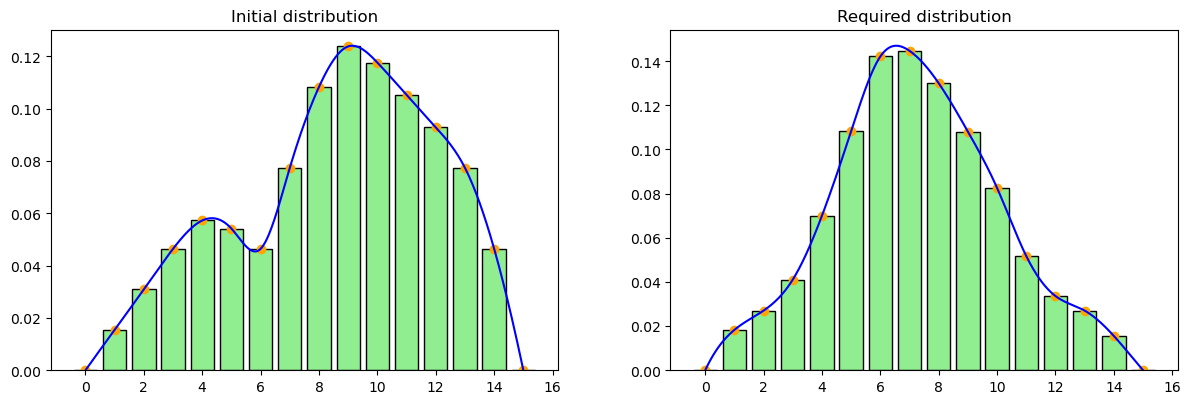

In [3]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Drawing both of them
figure, axis = plt.subplots(1, 2)
figure.set_figheight(4)
figure.set_figwidth(12)
figure.tight_layout(w_pad = 5)

def draw(y, id):
    x = np.array(range(0, np.size(y)))
    XYSpline = make_interp_spline(x, y) 
    X = np.linspace(x.min(), x.max(), 500)
    Y = XYSpline(X)
    axis[id].bar(x, y, color="lightgreen", ec='black')
    axis[id].scatter(x, y, color="orange")
    axis[id].plot(X, Y, color='blue')

axis[0].title.set_text("Initial distribution")
axis[1].title.set_text("Required distribution")
draw(a, 0)
draw(b, 1)

plt.show()

In order to better understand how Optimal Transport works, below is presented the code considering the case when the matrix cost distance is presented and defined as the absolute difference between positions of each part of the distribution. That is $\text{distance}[i][j] = abs(i - j)$.

In [4]:
import pandas as pd

_a = pd.Series(a)
_b = pd.Series(b)
distance = np.zeros((np.size(a), np.size(b)))
for i in range(np.size(a)):
    for j in range(np.size(b)):
        distance[i][j] = abs(i - j)

In [8]:
from aif360.sklearn.metrics import ot_distance
c0 = ot_distance(y_true=_a, y_pred=_b, cost_matrix=distance, mode='continuous')

print("Wasserstein distance is equal to ", c0, ".", sep="")

Wasserstein distance is equal to 1.3773703499999999.


### 2. Randomly distributed samples

Suppose we have two distributions $a$ and $b$ with length $N$, that are generated randomly, and we need to calculate earth_movers_distance for them.

In [6]:
import numpy as np

N = 1000
np.random.seed(seed=1)

# Initial distribution
a = np.random.rand(N)
a /= np.sum(a)

# Required distribution
b = np.random.rand(N)
b /= np.sum(b)

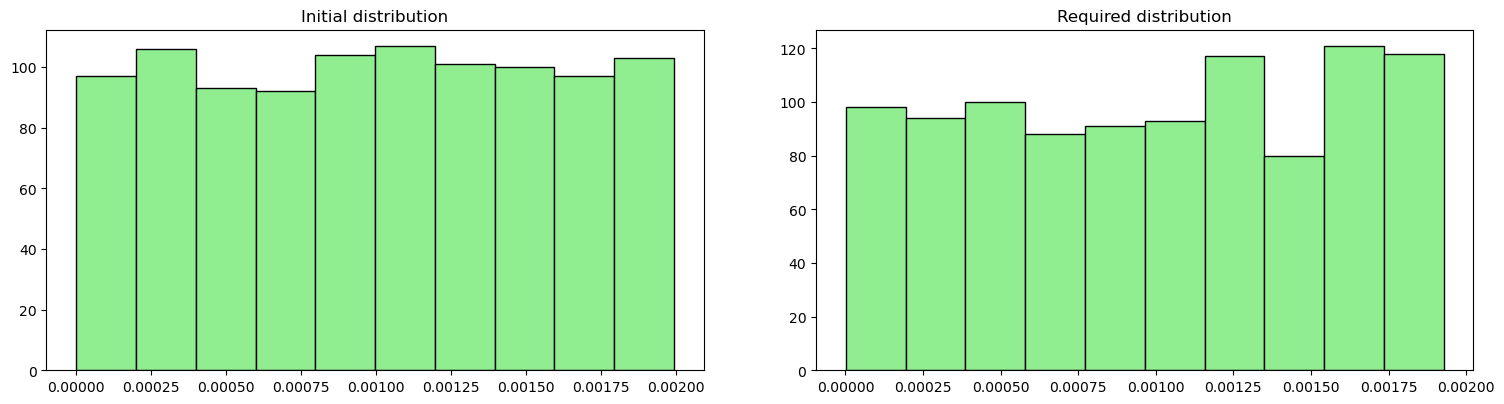

In [7]:
import matplotlib.pyplot as plt

# Drawing both of them
figure, axis = plt.subplots(1, 2)
figure.set_figheight(4)
figure.set_figwidth(15)
figure.tight_layout(w_pad = 5)

def draw(y, id):
    axis[id].hist(y, color='lightgreen', ec='black', bins=10)

axis[0].title.set_text("Initial distribution")
axis[1].title.set_text("Required distribution")
draw(a, 0)
draw(b, 1)

plt.show()

In this case the Wasserstein distance tends to zero as the size of the samples increase.

In [9]:
import pandas as pd
from aif360.sklearn.metrics import ot_distance

_a = pd.Series(a)
_b = pd.Series(b)
c = ot_distance(y_true=_a, y_pred=_b, mode='continuous')

print("Wasserstein distance is: ", c, ".", sep="")

Wasserstein distance is: 2.003382269162742e-05.


### 3. Permutations

Another example that shows clearly what the permutations in the first formula refer to is the one presented below.

In [10]:
import numpy as np

# Initial distribution
a = np.array([0., 0.1, 0.1, 0.1, 0.08, 0., 0.1, 0.1, 0.08, 0.08, 0., 0.1, 0.08, 0.08, 0.08, 0.])
# Required distribution
b = np.array([0., 0.08, 0.08, 0.08, 0.1, 0., 0.08, 0.08, 0.1, 0.1, 0., 0.08, 0.1, 0.1, 0.1, 0.])

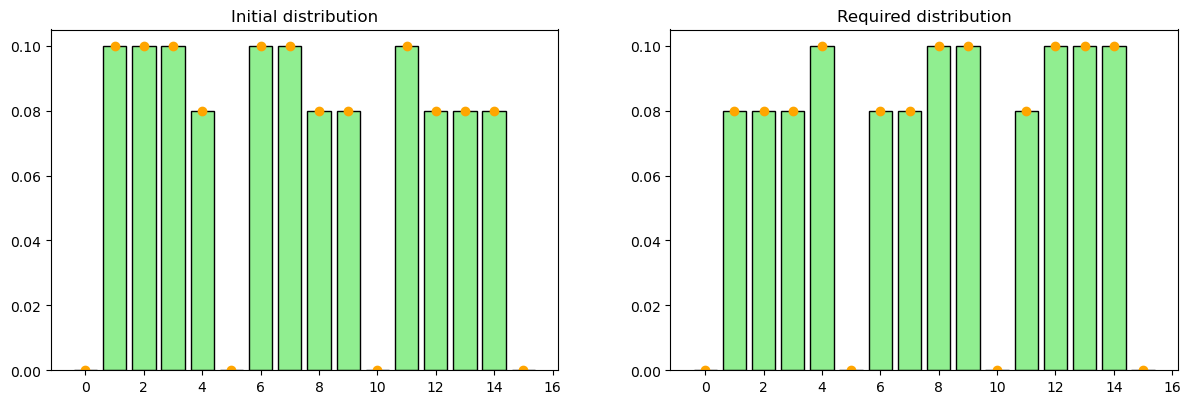

In [11]:
import matplotlib.pyplot as plt

# Drawing both of them
figure, axis = plt.subplots(1, 2)
figure.set_figheight(4)
figure.set_figwidth(12)
figure.tight_layout(w_pad = 5)

def draw(y, id):
    x = np.array(range(0, np.size(y)))
    axis[id].bar(x, y, color="lightgreen", ec='black')
    axis[id].scatter(x, y, color="orange")

axis[0].title.set_text("Initial distribution")
axis[1].title.set_text("Required distribution")
draw(a, 0)
draw(b, 1)

plt.show()

There, since we can go from the initial distribution to the desired one just using permutations, the Wasserstein distance is zero.

In [12]:
import pandas as pd
from aif360.sklearn.metrics import ot_distance

_a = pd.Series(a)
_b = pd.Series(b)
c = ot_distance(_a, _b, mode='continuous')

print(c)

0.0


### 4. Extreme case

One more example that is closer to our case is "normalization". It's an explanation of why the maximum Wasserstein distance we can get in our case is approaching 1 (with increasing the size of the sample), that is, it is normalized. We get this in the case that all our population has a value 0 of the 2-year recidivism (which is presented in the paragraph "Compas Dataset") and the classifier fails massively in all the cases labeling all with a 1. That would be the worst-case scenario.

In [13]:
import numpy as np

# Initial distribution
a = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.001])
# Required distribution
b = np.array([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625])

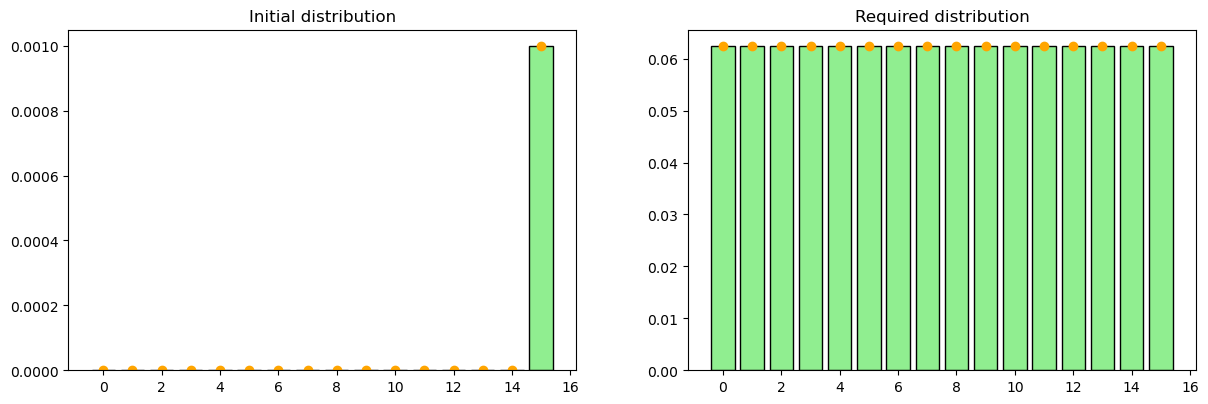

In [14]:
import matplotlib.pyplot as plt

# Drawing both of them
figure, axis = plt.subplots(1, 2)
figure.set_figheight(4)
figure.set_figwidth(12)
figure.tight_layout(w_pad = 5)

def draw(y, id):
    x = np.array(range(0, np.size(y)))
    axis[id].bar(x, y, color="lightgreen", ec='black')
    axis[id].scatter(x, y, color="orange")

axis[0].title.set_text("Initial distribution")
axis[1].title.set_text("Required distribution")
draw(a, 0)
draw(b, 1)

plt.show()

In [15]:
import pandas as pd
from aif360.sklearn.metrics import ot_distance

_a = pd.Series(a)
_b = pd.Series(b)
c = ot_distance(_a, _b)

print(c)

0.9375


## Usage

The type of outcomes must be provided using the `mode` keyword argument. The definition for the four types of outcomes supported are provided below:
- Binary: Yes/no outcomes. Outcomes must 0 or 1.
- Continuous: Continuous outcomes. Outcomes could be any real number.
- Nominal: Multiclass outcomes with no rank or order between them. Outcomes must be a finite set of integers.
- Ordinal: Multiclass outcomes that are ranked in a specific order. Outcomes must be positive integers.

## Compas Dataset

We'll demonstrate finding the scanning for bias with earth_movers_distance using the Compas dataset. We scan for bias in the predictions of an `sklearn` logistic regression model with respect to different groups.

In [23]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

import numpy as np
import pandas as pd

np.random.seed(0)
dataset_orig = load_preproc_data_compas()

We scan for bias at first with respect to `sex`, and then `age`.

To scan for bias with respect for a feature that is one-hot encoded - in this case, age category - we need to convert it to nominal or ordinal format.

In [24]:
dataset_orig_df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)
# Binning the features corresponding to age ('reshaping' them into one ordinal column)
age_cat_cols = ['age_cat=Less than 25', 'age_cat=25 to 45', 'age_cat=Greater than 45']
age_cat = np.argmax(dataset_orig_df[age_cat_cols].values, axis=1).reshape(-1, 1)
df = dataset_orig_df.drop(age_cat_cols, axis=1)
df['age_cat'] = age_cat
df['two_year_recid'] = dataset_orig.labels
df.head()

,sex,race,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,age_cat,two_year_recid
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1,0.0


### Measuring bias with respect to `sex`


We train a linear regression model on the dataset, and scan its results for bias with respect to `sex` using `earth_movers_distance`.

The arguments are as follows:
- `ground_truth`: ground truth labels;
- `classifier`: predicted labels;
- `prot_attr`: the values of the sensitive attributes (with respect to which the classifier may be introducing bias);
- `num_iters`: maximum number of iterations performed when calculating the Earth Mover's Distance;
- `mode`: mode of the labels, one of binary, nominal, ordinal and continious; in our case the labels are binary.

In [25]:
from aif360.sklearn.metrics import ot_distance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']
clf = LogisticRegression(solver='lbfgs', max_iter=10000, C=1.0, penalty='l2')
clf.fit(X, y)
preds = pd.Series(clf.predict_proba(X)[:,0])

ot_val1 = ot_distance(y_true=y, y_pred=preds, prot_attr=df['sex'])

In [26]:
bs1 = pd.DataFrame({"sex": ot_val1.keys(), "ot_val": ot_val1.values()})
display(bs1)

,sex,ot_val
0,0.0,0.000209
1,1.0,0.001647


We get the bias value for each each of the protected groups - in this case, Male (`0`) and Female (`1`). 

These values range from 0 to 1 and can be interpreted as the difference in percent between the ground truth distribution and the distribution of the protected group: for example, a value of 0.3 would mean a 30% difference.

### Measuring bias with respect to `age_cat`

Now we measure the bias of the same classifier with respect to the age category.

In [27]:
ot_val2 = ot_distance(y_true=y, y_pred=preds, prot_attr=df['age_cat'])

In [28]:
bs2 = pd.DataFrame({"age_cat": ot_val2.keys(), "ot_val": ot_val2.values()})
display(bs2)

,age_cat,ot_val
0,0,0.000578
1,1,0.000313
2,2,0.001800


## Adult Dataset

Let us consider the Adult Dataset. It has two protected categories: `sex` and `race`.

In [29]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

import numpy as np
import pandas as pd

In [30]:
data_raw = load_preproc_data_adult()
data = data_raw.convert_to_dataframe()[0]
data.head()

,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Measuring bias with respect to `sex`

In [31]:
clf = LogisticRegression(solver='lbfgs', max_iter=10000, C=1.0, penalty='l2')
X = data.drop('Income Binary',axis=1)
y = data['Income Binary']

clf.fit(X, y)
preds = pd.Series(clf.predict_proba(X)[:,0])

ot_val1 = ot_distance(y_true=y, y_pred=preds, prot_attr=data['sex'])

In [32]:
bs1 = pd.DataFrame({"sex": ot_val1.keys(), "ot_val": ot_val1.values()})
display(bs1)

,sex,ot_val
0,0.0,0.000503
1,1.0,0.000067


### Measuring bias with respect to `race`

In [33]:
ot_val2 = ot_distance(y_true=y, y_pred=preds, prot_attr=data['race'])

In [34]:
bs2 = pd.DataFrame({"race": ot_val2.keys(), "ot_val": ot_val2.values()})
display(bs2)

,race,ot_val
0,0.0,0.000779
1,1.0,0.000068


## More details

It is commonly employed as a means to quantify the similarity between distributions, particularly when the distributions have distinct supports. In scenarios where the supports of the distributions are disjoint, OT-based Wasserstein distances offer favorable comparisons to well-known f-divergences such as the Kullback-Leibler divergence, Jensen-Shannon divergence, and Total Variation distance.

One notable aspect that makes OT valuable for data science applications is its ability to compute meaningful sub-gradients of the Wasserstein distance. This feature enhances its efficiency as a tool for measuring and optimizing similarity between empirical distributions.

The machine learning (ML) literature has seen numerous contributions utilizing OT as an approach. For instance, in the training of Generative Adversarial Networks (GANs), OT has been utilized to tackle the issue of vanishing gradients, which can hinder the learning process. Additionally, OT has been employed to identify discriminant or robust subspaces within datasets, offering useful insights. Moreover, the Wasserstein distance has found application in measuring similarity between word embeddings of documents, as well as comparing signals or spectra.

Due to the inherent constraint in the problem, solving Optimal Transport (OT) can be quite challenging. As a result, in practical applications dealing with discrete distributions, a more manageable approach known as a linear program has been employed as a substitute. This approach corresponds to the Kantorovitch formulation, where the original Monge mapping, denoted as $m$ is replaced by a joint distribution represented by an OT matrix.
From the optimization problem described above, we can identify two primary components of the OT solution that have practical applications:
- The optimal value (Wasserstein distance): This quantifies the similarity between distributions. It is used to measure the dissimilarity or similarity between datasets or distributions. The Wasserstein distance represents the optimal value obtained from solving the OT problem.
- The optimal mapping (Monge mapping or OT matrix): This determines the correspondences between the distributions. It describes how the mass is transported between the source and target distributions. The optimal mapping can be utilized to transfer knowledge or information between distributions.

In the first case, OT is employed to assess the similarity between distributions or datasets. Here, the Wasserstein distance, which is the optimal value obtained from solving the OT problem, is used as a measure of similarity. In the second case, the focus lies on understanding the specific manner in which mass is transferred between distributions, represented by the mapping. This mapping can be leveraged to facilitate the transfer of knowledge or information between the distributions.


### OT for mapping estimation

One fascinating aspect of the Optimal Transport (OT) problem is the inherent OT mapping. When computing the optimal transport between discrete distributions, one of the outputs is the OT matrix, which provides correspondences between the samples in each distribution.

This correspondence is estimated based on the OT criterion and is obtained in a non-supervised manner. This characteristic makes it particularly intriguing for problems involving dataset transfer. OT has been employed, for instance, in performing color transfer between images or in the context of domain adaptation, where knowledge or information is transferred between different datasets.

Furthermore, more recent applications have explored the extension of OT, known as Gromov-Wasserstein, to establish correspondences between languages using word embeddings. This utilization of OT enables the identification of connections or similarities between languages based on the distributional properties of word embeddings.



### Kantorovich optimal transport problem

This is the most typical OT problem. It seeks an optimal coupling $\boldsymbol{T}$ which minimizes the displacement cost of a discrete measure $\boldsymbol{a}$ to a discrete measure $\boldsymbol{b}$ with respect to a ground cost $\boldsymbol{M} \in \mathbb{R}^{n_{1} \times n_{2}}$. In order to be a transport plan, $\boldsymbol{T}$ must be part of the set $\Pi(\mathbf{a}, \mathbf{b})=\left\{\boldsymbol{T} \geq \mathbf{0}, \boldsymbol{T} \mathbf{1}_{n_{2}}=\boldsymbol{a}, \boldsymbol{T}^{\top} \mathbf{1}_{n_{1}}=\boldsymbol{b}\right\}$. When the ground cost is a metric, the optimal value of the OT problem is also a metric (Rubner et al., 2000; Cuturi and Avis, 2014) and is called the Wasserstein distance. In this discrete case, the OT problem is defined as

$$
W_{M}(\boldsymbol{a}, \boldsymbol{b})=\min _{\boldsymbol{T} \in \Pi(\mathbf{a}, \mathbf{b})}\langle\boldsymbol{T}, \boldsymbol{M}\rangle
$$

which is a linear program. The optimization problem above is often adapted to include a regularization term for the transport plan $\boldsymbol{T}$, such as entropic regularization (Cuturi, 2013) or squared L2. For the entropic regularized OT problem, one may use the Sinkhorn Knopp algorithm (or variants), or stochastic optimization algorithms. POT has a simple syntax to solve these problems.

### Solving optimal transport

The optimal transport problem between discrete distributions is often expressed as
$$
\begin{array}{r}
\gamma^*=\arg \min _{\gamma \in \mathbb{R}_{+}^{m \times n}} \sum_{i, j} \gamma_{i, j} M_{i, j} \\
\text { s.t. } \gamma 1=a ; \gamma^T 1=b ; \gamma \geq 0
\end{array}
$$
where:
- $M \in \mathbb{R}_{+}^{m \times n}$ is the metric cost matrix defining the cost to move mass from bin $a_i$ to bin $b_j$.
- $a$ and $b$ are histograms on the simplex (positive, sum to 1) that represent the weights of each samples in the source an target distributions.
Solving the linear program above can be done using the function ot.emd that will return the optimal transport matrix $\gamma^*$ :

### The necessity and priority of usage

The main difference between the MDSS and OT detectors is the range of applicability. MDSS scanner can in linear time decide, what the most anomalous subset is, while in the case of OT detector has a narrower but more accurate field of use. The method used can only account for 1-dimensional histograms as precisely described in "POT: Python Optimal Transport" https://jmlr.org/papers/v22/20-451.html. This means there is no possibility yet to handle datasets of more than 1 feature. For more dimensions, there is a prospect for the Sinkhorn algorithm, which will be implemented in the nearest future. As compared to MDSS, the user needs to specify the sensitive attribute for which wants to know the bias. 

So if the user is interested in obtaining a certain bias on a particular parameter, it is better to use earth_movers_distance. But if it is more important to see the general picture for all parameters on bias presence, then it is better to use MDSS.

The matrix that is obtained from the emd method is called a transport plan in the OT framework (the gamma matrix in https://pythonot.github.io/all.html?highlight=emd#ot.emd). It is the matrix which minimizes the transportation cost, and workable to evaluate the actual Wasserstein distance by taking the Frobenius product (see here for instance: https://en.wikipedia.org/wiki/Frobenius_inner_product) with the metric cost matrix, M.